# scNT-seq: human hematopoiesis dynamics

This tutorial demonstrates comprehensive analysis of single-cell hematopoiesis dynamics using {mod}`dynamo` with scNT-seq metabolic labeling data. We show how to perform absolute total RNA velocity analyses with the metabolic labeling datasets reported in the dynamo Cell paper, reproducing the total RNA velocity analyses from figure 3B. The {mod}`dynamo` package includes processed hematopoiesis data accessible via {meth}`dynamo.sample_data.hematopoiesis`.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import dynamo as dyn

dyn.configuration.set_figure_params('dynamo', background='white')
dyn.pl.style(font_path='Arial')
dyn.get_all_dependencies_version()

%load_ext autoreload
%autoreload 2

Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



package,umap-learn,typing-extensions,tqdm,statsmodels,setuptools,session-info,seaborn,scipy,requests,pynndescent,pre-commit,pandas,openpyxl,numdifftools,numba,networkx,mudata,matplotlib,loompy,leidenalg,igraph,dynamo-release,colorcet,anndata
version,0.5.7,4.13.2,4.67.1,0.14.4,79.0.0,1.0.1,0.13.2,1.11.4,2.32.3,0.5.13,4.2.0,2.2.3,3.1.5,0.9.41,0.60.0,3.4.2,0.3.1,3.10.3,3.0.8,0.10.2,0.11.8,1.4.2rc1,3.1.0,0.11.4


First let us download the raw hematopoiesis data via {func}`dynamo.sample_data.hematopoiesis_raw`. The `new` and `total` layers correspond to the labeled RNA and total RNA and will be used for total RNA velocity analyses estimation. Note that in order to ensure the reproducibility, we will also included the umap embedding in `.obsm['X_umap']` generated previously.

In [2]:
adata_hsc_raw = dyn.sample_data.hematopoiesis_raw()
adata_hsc_raw

|-----> Downloading raw hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis_raw.h5ad
|-----> in progress: 99.6166%|-----> [download] completed [25.8852s]


AnnData object with n_obs × n_vars = 1947 × 26193
    obs: 'batch', 'cell_type', 'time'
    var: 'gene_name_mapping'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced'

We use the monocle recipe to preprocess the `adata` object. Importantly, to ensure the reproducibility, we also use a predefined gene list that includes the highly variable genes and known markers genes based on previous reports ([Paul, cell, 2015](https://pubmed.ncbi.nlm.nih.gov/26627738/), [Weintrab, Science, 2020](https://pubmed.ncbi.nlm.nih.gov/31974159/), etc). The gene list is stored in `adata_hsc_raw.uns["genes_to_use"]` of the hematopoiesis raw dataset came with {mod}`dynamo`. 

Note that the `time` key indicates the RNA metabolic labeling duration. Since we labeled cells from the same harvest time point for a single time pulse, so the experiment_type is set to be "one-shot" (although we labeled cells at day 7 for 3 hours while cells at day 10 for 5 hours).

In [3]:
selected_genes_to_use = adata_hsc_raw.uns["genes_to_use"]

In [4]:
preprocessor = dyn.pp.Preprocessor(force_gene_list=selected_genes_to_use)
preprocessor.config_monocle_recipe(adata_hsc_raw, n_top_genes=len(selected_genes_to_use))                               
preprocessor.preprocess_adata_monocle(
    adata_hsc_raw,
    tkey="time",
    experiment_type="one-shot",
)

|-----> Running monocle preprocessing pipeline...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
16 input query terms found dup hits:	[('ENSG00000226519', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000234162', 2), ('E
458 input query terms found no hit:	['ENSG00000112096', 'ENSG00000132832', 'ENSG00000168078', 'ENSG00000176659', 'ENSG00000189144', 'ENS


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.
|-----------> filtered out 0 outlier cells
|-----------> filtered out 18914 outlier genes
|-----> OVERWRITE all gene selection results above according to user gene list inputs. 2101 genes in use.
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [54.2866s]


In [5]:
adata_hsc_raw.var.use_for_pca.sum()

1742

In [6]:
dyn.tl.reduceDimension(adata_hsc_raw)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [0.1845s]


## Estimate RNA velocity with the Model 2

In general, {mod}`dynamo` supports two major models for estimating kinetic parameters and RNA velocity for tscRNA-seq data. The Model 2 doesn't consider RNA splicing while Monocle 3 does (see Fig. SI2. A).

Note that we also use labeling time to group cells for gene expression smoothing via {func}`dynamo.tl.moments`.

In [7]:
dyn.tl.moments(adata_hsc_raw, group="time")

|-----> calculating first/second moments...
|-----> [moments calculation] completed [22.3706s]


Since we actually have unsplicing/splicing data in our adata, {mod}`dynamo`'s preprocess module automatically recognizes this and then tag the `adata` to have both splicing and labeling information. In order to use Model 2, here we purposely set `has_splicing` to be false, which then considers labeling data (new/total) while ignores unsplicing/splicing information.

Note that in order to ensure the reproducibility, we set `one_shot_method="sci_fate", model="deterministic"` but running with default parameters will give you very similar results.

In [8]:
adata_hsc_raw.uns["pp"]["has_splicing"] = False
dyn.tl.dynamics(adata_hsc_raw, group="time",
                one_shot_method="sci_fate", model="deterministic");


|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] completed [4.2174s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1742/1742 [00:00<00:00, 61388.14it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] completed [2.8748s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1742/1742 [00:00<00:00, 62985.79it/s]


Next, because we actually quantified both the labeling and splicing information, we used the second formula that involves both splicing and labeling data to define total RNA velocity ($\dot{r} = n / (1 - e^{-rt}) \cdot r - \gamma s$) where $r, n, t, \gamma, s$ are total RNA, new RNA, labeling time, splicing rate and spliced RNA respectively. 

Once the high-dimensional total RNA velocities are calculated, we will then projected them to two-dimensional UMAP space and visualized with the streamline plot, using {mod}`dynamo` with default parameters ({func}`dynamo.tl.cell_velocities`).

In [9]:
adata_hsc_raw.obs.time.unique()

array([3, 5])

In [11]:
adata_hsc_raw

AnnData object with n_obs × n_vars = 1947 × 21595
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr'
    var: 'gene_name_mapping', 'nCells', 'nCounts', 'query', 'scopes', '_id', '_score', 'symbol', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b

We have two time points in hsc dataset. Here we split the dataset based on time points and prepare data for calculation next.

In [10]:
# Usage
dyn.tl.calculate_velocity_alpha_minus_gamma_s(adata_hsc_raw)

Found 2 unique time points: [3. 5.]
Processing time point: 3.0
  Number of cells: 1129
  Velocity calculation completed for time point 3.0
Processing time point: 5.0
  Number of cells: 818
  Velocity calculation completed for time point 5.0
Total RNA velocity stored in adata.layers['velocity_alpha_minus_gamma_s']


Next, we will calculate `total RNA velocity` according to $$\dot{r} = n / (1 - e^{-rt}) \cdot r - \gamma s$$

The results are stored in `adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"]`, which can be further projected to low dimension space for visualization.

In [11]:
dyn.tl.cell_velocities(
    adata_hsc_raw,
    enforce=True,
    X=adata_hsc_raw.layers["M_t"],
    V=adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
);

|-----> 177 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [367.0748s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.5801s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


Now let us plot the total RNA stream line plot and visualize the PF4 gene expression on the UMAP space with default parameters. This reproduces total RNA velocity streamline plot in Figure 3B and Figure 3C using {func}`dynamo.pl.streamline_plot`.

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap


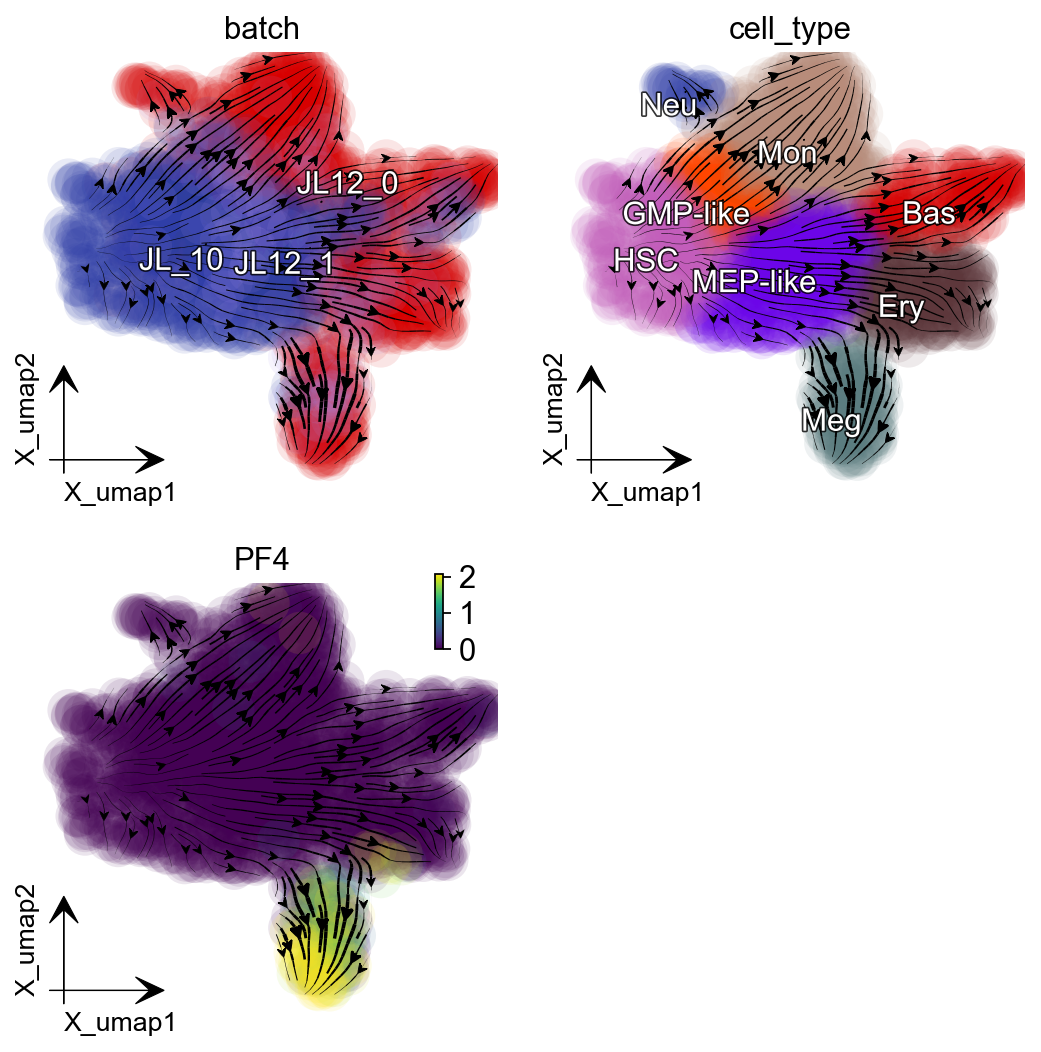

In [15]:
dyn.pl.streamline_plot(
    adata_hsc_raw,
    color=["batch", "cell_type", "PF4"],
    ncols=2,
    basis="umap",
    s_kwargs_dict={'adjust_legend':True,'dpi':80},
    figsize=(4,4)
)

Here we can also visualize the total RNA phase diagram in Figure 3E using {mod}`dynamo` with default settings.